# Question 8

This script determines the number of years in a solar cycle using annual sunspot
data.

In [95]:
from pathlib import Path
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.fft import fft, fftfreq
from scipy.signal.windows import blackman, boxcar, hann

from config import A1_ROOT, SAVEFIG_CONFIG

In [3]:
data = pd.read_csv(Path(A1_ROOT, "data", "SunspotData.csv"))

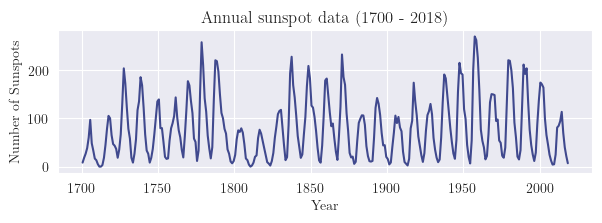

In [4]:
# Plot the time series data
fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

sns.lineplot(data, x="Year", y="Number of Sunspots", ax=ax)
ax.set_title("Annual sunspot data (1700 - 2018)")

fname = Path(A1_ROOT, "output", "q8_timeseries.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

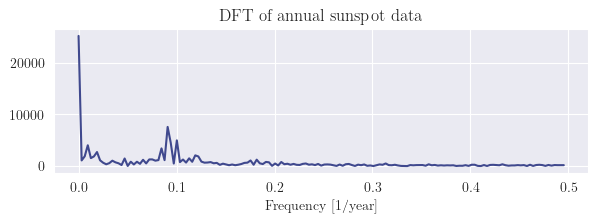

In [5]:
# Plot the DFT
N = data["Year"].count()
f = fftfreq(N, 1)[:N//2]
H = np.abs(fft(data["Number of Sunspots"].to_numpy())[:N//2])

fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

sns.lineplot(x=f, y=H, ax=ax)

ax.set_title("DFT of annual sunspot data")
ax.set_xlabel("Frequency [1/year]")

fname = Path(A1_ROOT, "output", "q8_rawdft.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

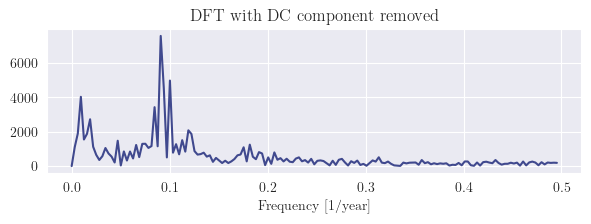

In [6]:
# Remove the DC component and plot the DFT again
x = (data["Number of Sunspots"] - data["Number of Sunspots"].mean()).to_numpy()
H = np.abs(fft(x)[:N//2])

fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

sns.lineplot(x=f, y=H, ax=ax)

ax.set_title("DFT with DC component removed")
ax.set_xlabel("Frequency [1/year]")

fname = Path(A1_ROOT, "output", "q8_nodcdft.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

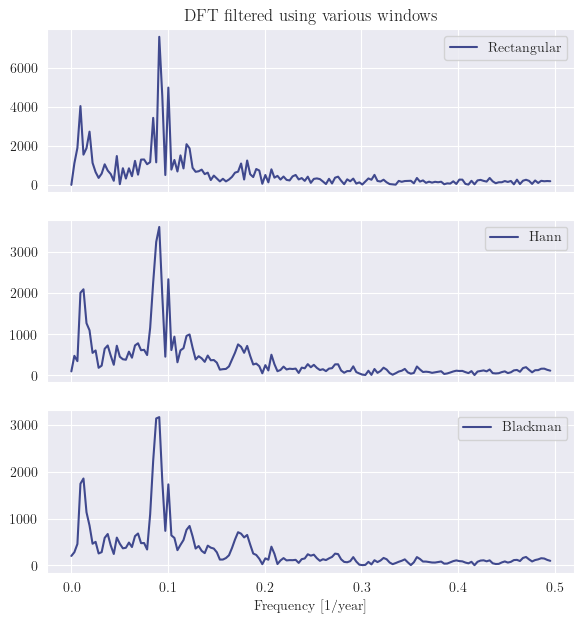

In [7]:
# Try filtering the signal using each of: blackman, boxcar, and hann windows
fig, axs = plt.subplots(3, figsize=(6, 6), sharex=True)
fig.tight_layout()

# 1. Boxcar (rectangular) window 
x_boxcar = x * boxcar(N)
H_boxcar = np.abs(fft(x_boxcar)[:N//2])
sns.lineplot(x=f, y=H_boxcar, ax=axs[0], label="Rectangular")

# 2. Hann window
x_hann = x * hann(N)
H_hann = np.abs(fft(x_hann)[:N//2])
sns.lineplot(x=f, y=H_hann, ax=axs[1], label="Hann")

# 3. Blackman window
x_blackman = x * blackman(N)
H_blackman = np.abs(fft(x_blackman)[:N//2])
sns.lineplot(x=f, y=H_blackman, ax=axs[2], label="Blackman")

axs[0].set_title("DFT filtered using various windows")
axs[2].set_xlabel("Frequency [1/year]")

fname = Path(A1_ROOT, "output", "q8_windowed.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

Find maxima using coarse and fine peak search algorithm<sup>1</sup>.

In [76]:
def coarse_search(x: np.array, T: float, k: float = 2, 
        clip: Tuple[float, float] = None) -> float:
    """
    Performs the coarse search algorithm described by Rife and Boorstyn [1].
    The factor `k` is equivalent to (M/N) in [1].
    """
    z = np.concatenate([k * x, np.zeros(len(x) * (k - 1))])
    f = fftfreq(len(z), T)[:len(z)//2]
    B = np.abs(fft(z)[:len(z)//2])
    B = B if not clip else B[(f >= clip[0]) & (f <= clip[1])]
    f = f if not clip else f[(f >= clip[0]) & (f <= clip[1])]
    return f[(B == B.max())][0]

rough_max_1 = coarse_search(x_blackman, T=1, k=2, clip=(0.00, 0.05))
rough_max_2 = coarse_search(x_blackman, T=1, k=2, clip=(0.05, 0.15))

print("Coarse search:", [rough_max_1, rough_max_2], "[1/years]")
print("              ", [1/rough_max_1, 1/rough_max_2], "[years]")

Coarse search: [0.0109717868338558, 0.08934169278996865] [1/years]
               [91.14285714285714, 11.192982456140351] [years]


In [98]:
def root_secant(f: Callable, x0: float, x1: float, maxiter: int = 100) -> float:
    """
    Performs the secant method root finding algorithm on the function `f`(x),
    with initial guesses `x0` and `x1`. The initial guesses should be close to 
    the desired zero. Returns the root found.
    """
    def stop_condition_met(xi: float, xj: float) -> bool:
        """
        Conditions to terminate the root search and return the latest value.
        """
        return (xj == 0) or np.isclose(xi, xj, rtol=0, atol=5e-4)

    while ((maxiter := maxiter - 1) > 0):
        x0 = x1 - f(x1) * (x1 - x0) / (f(x1) - f(x0))
        if (stop_condition_met(x1, x0)):
            return x0
        x1 = x0 - f(x0) * (x0 - x1) / (f(x0) - f(x1))
        if (stop_condition_met(x0, x1)):
            return x1

    raise RuntimeError("secant method did not converge")

def fine_search(x: np.array, T: float, w0: float) -> float:
    """
    Performs the fine search algorithm described by Rife [2]. 
    
    Parameters:
        x - set of discrete time observations of length N
        T - sampling period of x
        w0 - initial guess at frequency maximising A(w)

    Returns:
        Fine approximation of frequency maximising A(w).
    """
    step = 1 / (5 * N * T)

    A = lambda w: sum(x[n] * np.exp(-1j * n * w * T) for n in range(N)) / N
    B = lambda w: np.abs(A(w))
    dB = lambda w: (B(w + step / 2) - B(w - step / 2)) / step
    dBf = lambda f: dB(2 * np.pi * f)

    step *= np.sign(dBf(w0))
    
    p = w0
    while (np.sign(dBf(p0 := p)) == np.sign(dBf(p := p0 + step))):
        continue

    return root_secant(dBf, p0, p)

fine_max_1 = fine_search(x_blackman, T=1, w0=rough_max_1)
fine_max_2 = fine_search(x_blackman, T=1, w0=rough_max_2)
print("Fine search:", [fine_max_1, fine_max_2], "[1/years]")
print("            ", [1/fine_max_1, 1/fine_max_2], "[years]")

Fine search: [0.011152801870022704, 0.08947384225381592] [1/years]
             [89.6635672052842, 11.176450846530528] [years]


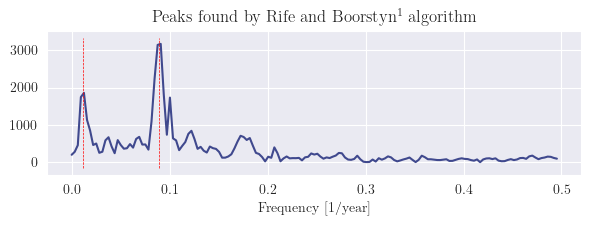

In [109]:
# Display the Blackman-windowed signal with identified frequencies overlayed
fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

sns.lineplot(x=f, y=H_blackman, ax=ax)

# Draw vertical lines at identified frequencies
ylim = ax.get_ylim()
ax.vlines(x=[fine_max_1, fine_max_2], ymin=ylim[0], ymax=ylim[1], color="r", 
    lw=0.5, ls="--")

ax.set_title("Peaks found by Rife and Boorstyn$^1$ algorithm")
ax.set_xlabel("Frequency [1/year]")

fname = Path(A1_ROOT, "output", "q8_searchresults.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

## References

[1] D. C. Rife and R. R. Boorstyn, "Single-tone parameter estimation from discrete-time observations," *IEEE Trans. Inf. Theory*, vol. IT-20, no. 5, pp. 591-598, Sep., 1974.

[2] D. C. Rife, "Digital tone parameter estimation in the presence of Gaussian noise," Ph.D. dissertation, Polytech. Inst. Brooklyn, Brooklyn, N.Y., Jun. 1973.

[3] Wikipedia. "Secant method." Wikipedia.org. https://en.wikipedia.org/wiki/Secant_method (accessed Aug. 14, 2023).